In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
# 读取数据
train_df = pd.read_csv('./data/train.csv')
print(train_df.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


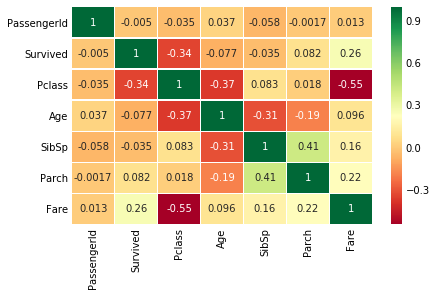

In [4]:
# 绘制热力图来查看先有各个特征之间的相关性
sns.heatmap(train_df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)


由上图可知：特征不显著相关。

## 缺失值填充

### 填充年龄缺失值

In [7]:
train_df['Initial'] = train_df.Name.str.extract('([A-Za-z]+)\.') 
train_df['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)
# 按照分组来求平均年龄
train_df.groupby('Initial')['Age'].mean()


Initial
Master     4.574167
Miss      21.860000
Mr        32.739609
Mrs       35.981818
Other     45.888889
Name: Age, dtype: float64

In [8]:
# 使用每组的均值来进行填充缺失值
train_df.loc[(train_df.Age.isnull())&(train_df.Initial=='Mr'),'Age']=33
train_df.loc[(train_df.Age.isnull())&(train_df.Initial=='Mrs'),'Age']=36
train_df.loc[(train_df.Age.isnull())&(train_df.Initial=='Master'),'Age']=5
train_df.loc[(train_df.Age.isnull())&(train_df.Initial=='Miss'),'Age']=22
train_df.loc[(train_df.Age.isnull())&(train_df.Initial=='Other'),'Age']=46

In [9]:
# 查看填充效果
train_df.Age.isnull().any()

False

### 填充港口缺失值

In [10]:
# 使用众数S
train_df.Embarked.fillna('S',inplace=True)
train_df.Embarked.isnull().any()

False

## 数据清洗

In [14]:
# 年龄特征离散化
# 将乘客的年龄分布分为5组，一组的年龄间距为16
train_df.loc[train_df['Age']<=16,'Age_band'] = 0;
train_df.loc[(train_df['Age']>16)&(train_df['Age']<=32),'Age_band'] = 1;
train_df.loc[(train_df['Age']>32)&(train_df['Age']<=48),'Age_band'] = 2;
train_df.loc[(train_df['Age']>48)&(train_df['Age']<=64),'Age_band'] = 3;
train_df.loc[train_df['Age']>64,'Age_band'] = 4;

In [15]:
train_df['Age_band'].value_counts()

1.0    382
2.0    325
0.0    104
3.0     69
4.0     11
Name: Age_band, dtype: int64

In [16]:
# 增加家庭总人口数
train_df['Family_num'] = train_df['Parch'] + train_df['SibSp']
# 增加是否孤独一人特征
train_df['Alone'] = 0
train_df.loc[train_df['Family_num']==0,'Alone'] = 1;

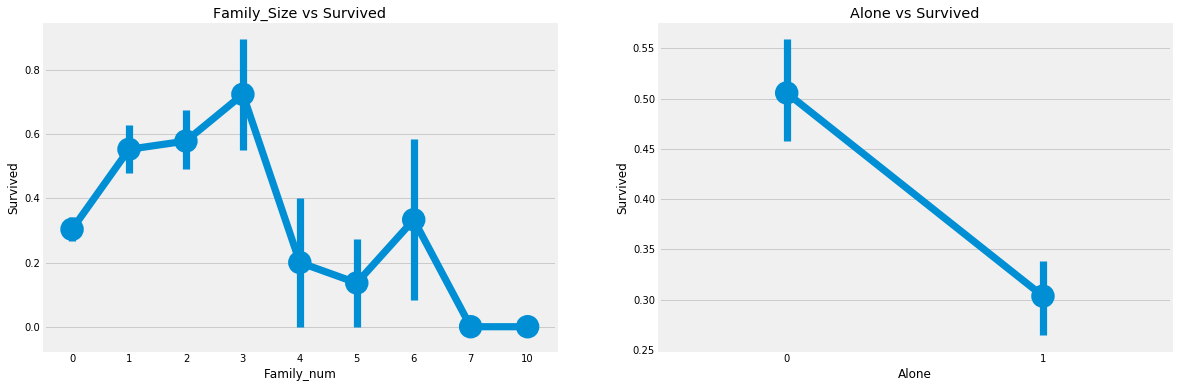

In [22]:
fig,ax = plt.subplots(1,2,figsize=(18,6))
sns.factorplot('Family_num','Survived',data=train_df,ax=ax[0])
ax[0].set_title('Family_Size vs Survived')

sns.factorplot('Alone','Survived',data=train_df,ax=ax[1])
ax[1].set_title('Alone vs Survived')

plt.close(2)
plt.close(3)

从上图可以看出来，孤独的人生还的可能性只有30%，与有亲属的相差较多，同时还可以看出，在亲属数量>=4个的时候，生还可能性开始下降

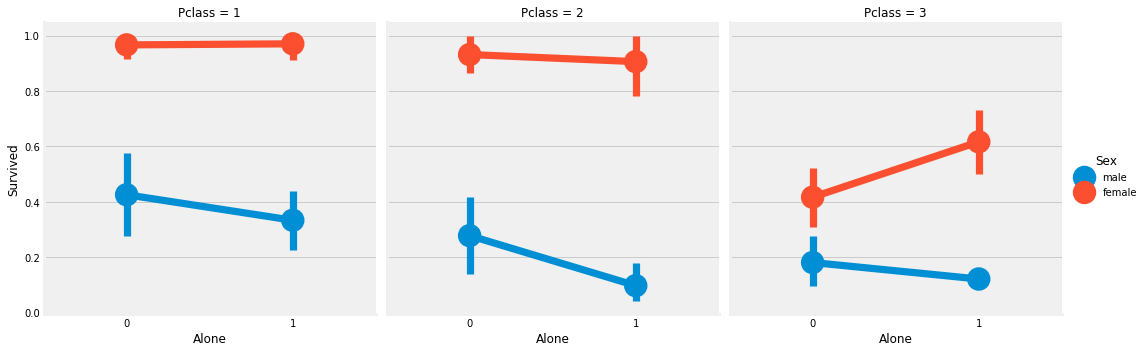

In [24]:
sns.factorplot('Alone','Survived',data=train_df,hue='Sex',col='Pclass')


In [27]:
# 船票离散化
train_df['Fare_range'] = pd.qcut(train_df['Fare'],4)
train_df.groupby(['Fare_range'])['Survived'].mean().to_frame()

,Survived
Fare_range,
"(-0.001, 7.91]",0.197309
"(7.91, 14.454]",0.303571
"(14.454, 31.0]",0.454955
"(31.0, 512.329]",0.581081


从上图可以看出，生存几率随船票价格增加而增加

In [28]:
train_df.loc[train_df['Fare']<=7.91,'Fare_cat'] = 0
train_df.loc[(train_df['Fare']>7.91)&(train_df['Fare']<=14.454),'Fare_cat']=1
train_df.loc[(train_df['Fare']>14.454)&(train_df['Fare']<=31),'Fare_cat']=2
train_df.loc[(train_df['Fare']>31)&(train_df['Fare']<=513),'Fare_cat']=3

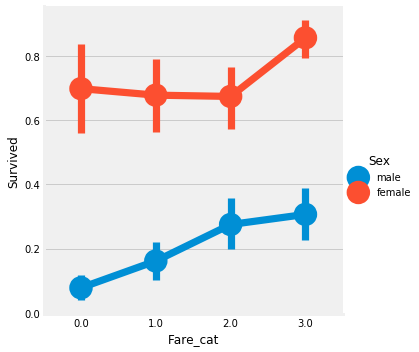

In [29]:
sns.factorplot('Fare_cat','Survived',hue='Sex',data=train_df)


In [30]:
# 将离散特征转化为数字
train_df['Sex'].replace(['male','female'],[0,1],inplace=True)
train_df['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
train_df['Initial'].replace(['Mr','Mrs','Miss','Master','Other'],[0,1,2,3,4],inplace=True)


In [32]:
# 去掉姓名、年龄、票号、票价、船舱号等特征
train_df.drop(['Name','Age','Ticket','Fare','Cabin','Fare_range','PassengerId'],axis=1,inplace=True)
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Sex           891 non-null int64
SibSp         891 non-null int64
Parch         891 non-null int64
Embarked      891 non-null int64
Initial       891 non-null int64
Age_band      891 non-null float64
Family_num    891 non-null int64
Alone         891 non-null int64
Fare_cat      891 non-null float64
dtypes: float64(2), int64(9)
memory usage: 76.6 KB


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5]),
 <a list of 11 Text yticklabel objects>)

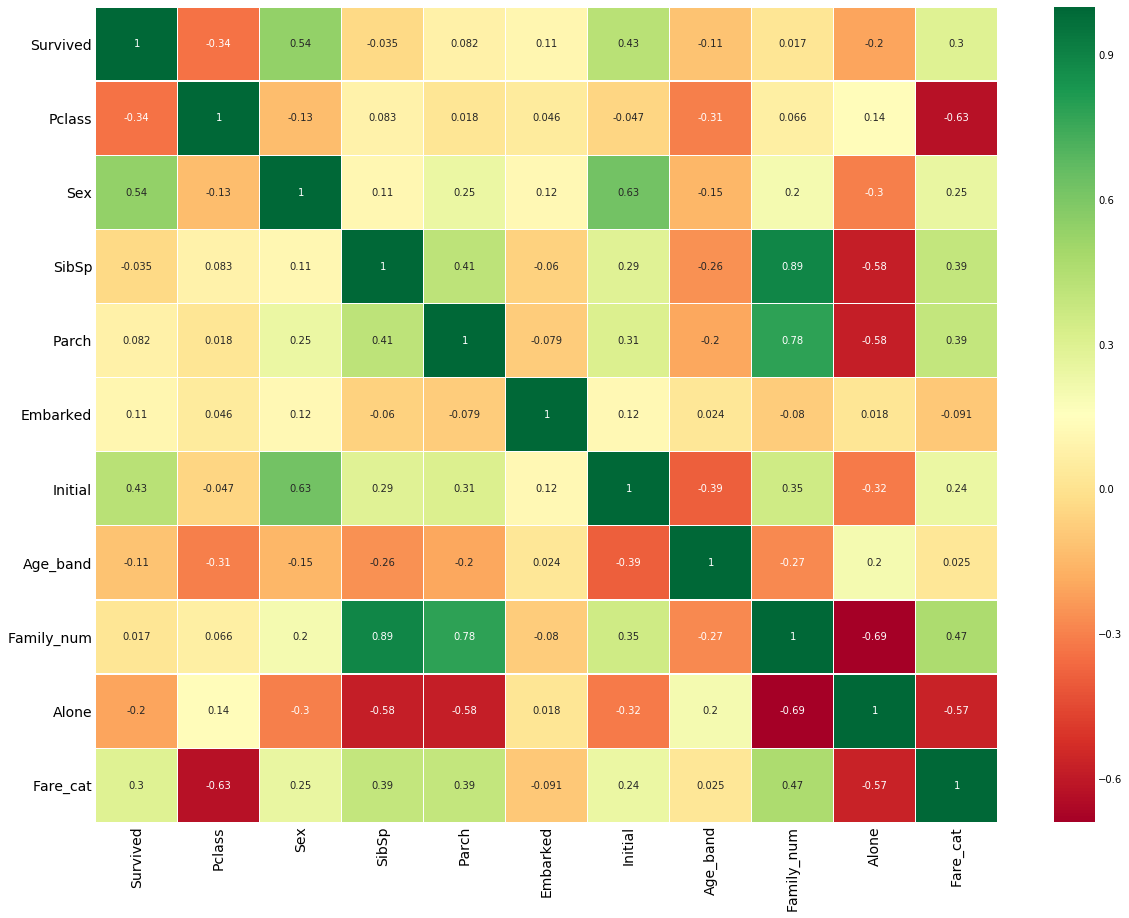

In [34]:
sns.heatmap(train_df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig = plt.gcf()
fig.set_size_inches(18,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


In [38]:
# 将处理后的数据暂时保存下来
train_df.to_csv('./data/processed_train.csv',encoding='utf-8',index=False)
